In [ ]:
!pip -q install transformers datasets accelerate

import json, time, math, os
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

# ----------------------------
# Config
# ----------------------------
MODEL_NAME = "gpt2-medium"
STEPS = 200
BATCH_SIZE = 1
MAX_LENGTH = 64
DATA_SPLIT = "train[:1%]"      # keep small/reproducible; change to 5% if you want
LR = 5e-5
PRINT_EVERY = 20
WARMUP_STEPS = 10              # helps stability
GRAD_CLIP = 1.0
OUTFILE = "baseline_results.json"
SEED = 42

# ----------------------------
# Repro + device
# ----------------------------
torch.manual_seed(SEED)
np.random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ----------------------------
# Data
# ----------------------------
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split=DATA_SPLIT)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def encode(ex):
    out = tokenizer(
        ex["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )
    return {"input_ids": out["input_ids"], "attention_mask": out["attention_mask"]}

dataset = dataset.map(encode, remove_columns=["text"])
dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ----------------------------
# Model
# ----------------------------
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.to(device)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# simple linear warmup then constant LR
def lr_scale(step):
    if step < WARMUP_STEPS:
        return (step + 1) / WARMUP_STEPS
    return 1.0

# ----------------------------
# Train loop (baseline)
# ----------------------------
losses = []
step_times = []

it = iter(loader)

start_total = time.time()

for step in range(1, STEPS + 1):
    try:
        batch = next(it)
    except StopIteration:
        it = iter(loader)
        batch = next(it)

    input_ids = batch["input_ids"].to(device)
    attn = batch["attention_mask"].to(device)

    # warmup LR
    for pg in optimizer.param_groups:
        pg["lr"] = LR * lr_scale(step - 1)

    t0 = time.time()

    optimizer.zero_grad(set_to_none=True)
    outputs = model(input_ids=input_ids, attention_mask=attn, labels=input_ids)
    loss = outputs.loss

    # safety check
    if not torch.isfinite(loss):
        print(f"❌ NaN/Inf loss at step {step}. Stopping.")
        break

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
    optimizer.step()

    t1 = time.time()

    losses.append(float(loss.item()))
    step_times.append(float(t1 - t0))

    if step % PRINT_EVERY == 0 or step == 1:
        print(f"[Baseline GPT2-M] step {step}/{STEPS} | loss={loss.item():.4f} | time={t1-t0:.3f}s | lr={optimizer.param_groups[0]['lr']:.2e}")

total_time = time.time() - start_total

# ----------------------------
# Results (for plots)
# ----------------------------
results = {
    "run": "Baseline (FP32)",
    "model": MODEL_NAME,
    "steps_requested": STEPS,
    "steps_completed": len(losses),
    "losses": losses,
    "times": step_times,
    "avg_loss": float(np.mean(losses)) if losses else None,
    "final_loss": float(losses[-1]) if losses else None,
    "avg_step_time_s": float(np.mean(step_times)) if step_times else None,
    "total_time_s": float(np.sum(step_times)) if step_times else None,
}

print("\n=== BASELINE SUMMARY ===")
for k, v in results.items():
    if k in ["losses", "times"]:
        continue
    print(f"{k}: {v}")

with open(OUTFILE, "w") as f:
    json.dump(results, f, indent=2)

print("\nSaved to:", OUTFILE)




Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


[Baseline GPT2-M] step 1/200 | loss=5.0296 | time=1.181s | lr=5.00e-06
[Baseline GPT2-M] step 20/200 | loss=0.8130 | time=0.067s | lr=5.00e-05
[Baseline GPT2-M] step 40/200 | loss=0.3727 | time=0.064s | lr=5.00e-05
[Baseline GPT2-M] step 60/200 | loss=0.0000 | time=0.087s | lr=5.00e-05
[Baseline GPT2-M] step 80/200 | loss=0.0000 | time=0.064s | lr=5.00e-05
[Baseline GPT2-M] step 100/200 | loss=0.0000 | time=0.071s | lr=5.00e-05
[Baseline GPT2-M] step 120/200 | loss=2.6623 | time=0.091s | lr=5.00e-05
[Baseline GPT2-M] step 140/200 | loss=0.0009 | time=0.077s | lr=5.00e-05
[Baseline GPT2-M] step 160/200 | loss=0.0002 | time=0.063s | lr=5.00e-05
[Baseline GPT2-M] step 180/200 | loss=0.3191 | time=0.085s | lr=5.00e-05
[Baseline GPT2-M] step 200/200 | loss=3.0886 | time=0.060s | lr=5.00e-05

=== BASELINE SUMMARY ===
run: Baseline (FP32)
model: gpt2-medium
steps_requested: 200
steps_completed: 200
avg_loss: 1.7628195760379548
final_loss: 3.0885918140411377
avg_step_time_s: 0.0765863740444183

In [ ]:
# =========================
# Compression Run (Delta + INT8 proxy comm) — GPT-2 Medium, 200 steps
# =========================

!pip install -q transformers datasets

import time, json
import torch
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# -------------------------
# Config (match your baseline)
# -------------------------
MODEL_NAME   = "gpt2-medium"
STEPS        = 200
BATCH_SIZE   = 1
MAX_LENGTH   = 64
DATA_SPLIT   = "train[:1%]"
LR           = 5e-5
PRINT_EVERY  = 20
OUTFILE      = "compressed_results.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Data
# -------------------------
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split=DATA_SPLIT)

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

def encode(ex):
    return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

dataset = dataset.map(encode, batched=True, remove_columns=["text"])
dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
it = iter(loader)

# -------------------------
# Model
# -------------------------
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# -------------------------
# Proxy comm measurement via hook:
# - "FP32 activations": numel * 4 bytes
# - "Delta + INT8": quantize (act - prev_act) to int8 => numel * 1 byte (+ tiny overhead for scale)
# This does NOT change training; it just measures what we'd send.
# -------------------------
fp32_bytes_total = 0
int8_bytes_total = 0

prev_act = None
hook_enabled = True

def quantized_delta_bytes(act: torch.Tensor):
    # act: [batch, seq, hidden] or similar
    global prev_act

    a = act.detach()
    if prev_act is None or prev_act.shape != a.shape:
        prev_act = a.clone()
        # first time: pretend we had to send full activation
        fp32_bytes = a.numel() * 4
        int8_bytes = a.numel() * 1  # still counting as "int8 payload" for proxy
        return fp32_bytes, int8_bytes

    delta = a - prev_act
    prev_act = a.clone()

    # simple symmetric int8 quantization: scale = max(|delta|)/127
    max_abs = delta.abs().max()
    if max_abs.item() == 0.0:
        scale = 1.0
    else:
        scale = (max_abs / 127.0).item()

    # payload bytes: int8 values + overhead for scale (float32)
    fp32_bytes = a.numel() * 4
    int8_bytes = a.numel() * 1 + 4  # +4 bytes for scale
    return fp32_bytes, int8_bytes

# Hook a consistent tensor to represent "communicated activations"
# We'll hook the output of the first transformer block.
target_module = model.transformer.h[0]

def hook_fn(module, inputs, output):
    global fp32_bytes_total, int8_bytes_total, hook_enabled
    if not hook_enabled:
        return
    # output is usually a tuple: (hidden_states, present, ...)
    hs = output[0] if isinstance(output, (tuple, list)) else output
    if torch.is_tensor(hs):
        fp32_b, int8_b = quantized_delta_bytes(hs)
        fp32_bytes_total += fp32_b
        int8_bytes_total += int8_b

hook_handle = target_module.register_forward_hook(hook_fn)

# -------------------------
# Train loop (STEPS)
# -------------------------
losses = []
step_times = []

for step in range(1, STEPS + 1):
    try:
        batch = next(it)
    except StopIteration:
        it = iter(loader)
        batch = next(it)

    input_ids = batch["input_ids"].to(device)
    attn_mask = batch["attention_mask"].to(device)

    t0 = time.time()
    optimizer.zero_grad(set_to_none=True)

    outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=input_ids)
    loss = outputs.loss

    # safety: catch NaNs/Infs early (you’ve seen this movie already)
    if not torch.isfinite(loss):
        print(f"❌ NaN/Inf loss at step {step}. Stopping.")
        break

    loss.backward()
    optimizer.step()

    dt = time.time() - t0
    losses.append(float(loss.item()))
    step_times.append(float(dt))

    if step % PRINT_EVERY == 0 or step == 1 or step == STEPS:
        print(f"[Compression Delta+INT8] step {step}/{STEPS} | loss={loss.item():.4f} | time={dt:.3f}s")

# Turn off hook after run
hook_enabled = False
hook_handle.remove()

# -------------------------
# Summary + save
# -------------------------
steps_completed = len(losses)
avg_loss = sum(losses) / steps_completed if steps_completed else float("nan")
final_loss = losses[-1] if steps_completed else float("nan")
avg_step_time = sum(step_times) / steps_completed if steps_completed else float("nan")
total_time = sum(step_times)

saved_pct = (1.0 - (int8_bytes_total / fp32_bytes_total)) * 100.0 if fp32_bytes_total else 0.0

results = {
    "run": "Compression (Delta + INT8)",
    "model": MODEL_NAME,
    "steps_requested": STEPS,
    "steps_completed": steps_completed,
    "avg_loss": avg_loss,
    "final_loss": final_loss,
    "avg_step_time_s": avg_step_time,
    "total_time_s": total_time,
    "fp32_bytes_total": int(fp32_bytes_total),
    "int8_bytes_total": int(int8_bytes_total),
    "proxy_comm_saved_pct": float(saved_pct),
    "losses": losses,
    "times": step_times,
}

print("\n=== COMPRESSION SUMMARY ===")
for k, v in results.items():
    if k in ["losses", "times"]:
        continue
    print(f"{k}: {v}")

with open(OUTFILE, "w") as f:
    json.dump(results, f, indent=2)

print("\nSaved to:", OUTFILE)


Device: cuda


Map:   0%|          | 0/367 [00:00<?, ? examples/s]

[Compression Delta+INT8] step 1/200 | loss=11.6033 | time=0.168s
[Compression Delta+INT8] step 20/200 | loss=1.8207 | time=0.067s
[Compression Delta+INT8] step 40/200 | loss=0.6624 | time=0.066s
[Compression Delta+INT8] step 60/200 | loss=1.2618 | time=0.062s
[Compression Delta+INT8] step 80/200 | loss=3.5058 | time=0.057s
[Compression Delta+INT8] step 100/200 | loss=0.0008 | time=0.068s
[Compression Delta+INT8] step 120/200 | loss=1.5899 | time=0.060s
[Compression Delta+INT8] step 140/200 | loss=0.4656 | time=0.063s
[Compression Delta+INT8] step 160/200 | loss=4.1405 | time=0.060s
[Compression Delta+INT8] step 180/200 | loss=3.1693 | time=0.057s
[Compression Delta+INT8] step 200/200 | loss=0.0004 | time=0.108s

=== COMPRESSION SUMMARY ===
run: Compression (Delta + INT8)
model: gpt2-medium
steps_requested: 200
steps_completed: 200
avg_loss: 1.5802817013542516
final_loss: 0.0003682757669594139
avg_step_time_s: 0.07009439826011658
total_time_s: 14.018879652023315
fp32_bytes_total: 524288

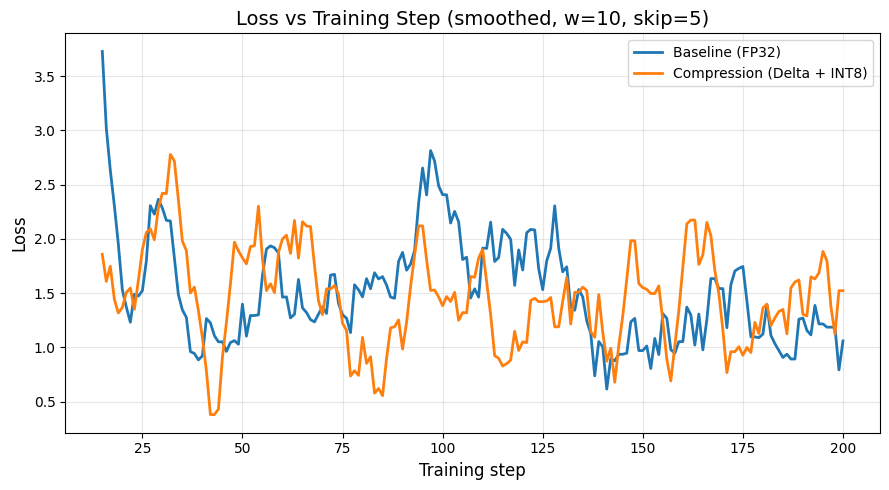

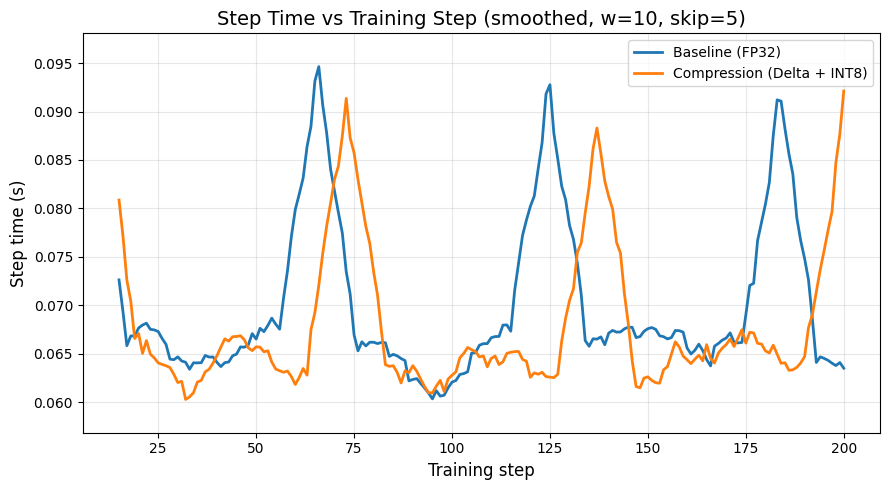

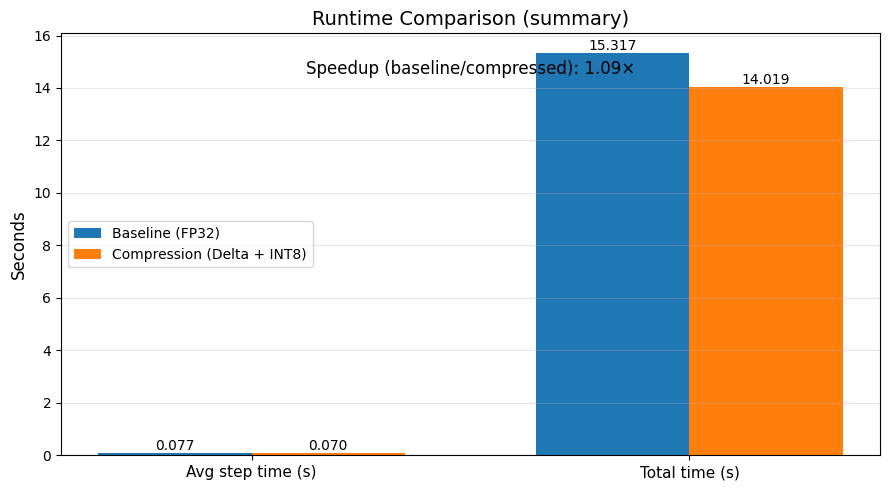

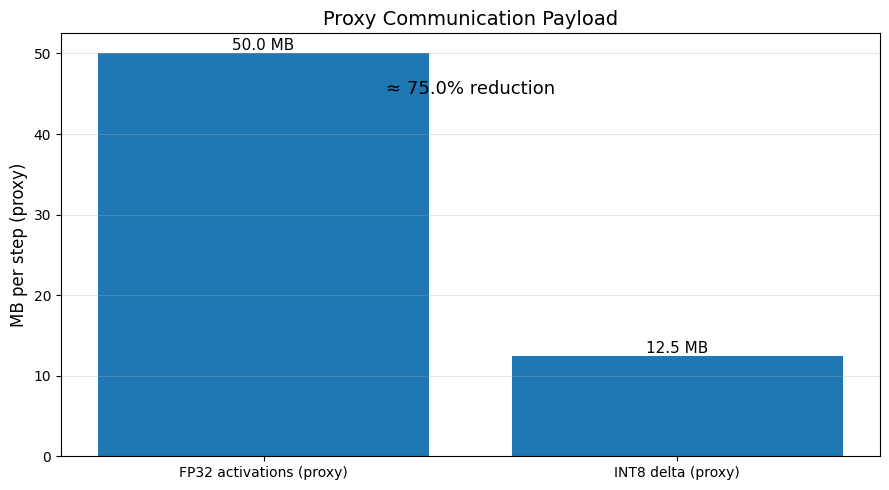

In [ ]:
import json, numpy as np
import matplotlib.pyplot as plt

BASELINE_JSON = "baseline_results.json"
COMPRESSED_JSON = "compressed_results.json"

def load_results(path):
    with open(path, "r") as f:
        return json.load(f)

b = load_results(BASELINE_JSON)
c = load_results(COMPRESSED_JSON)

# --- Helpers ---
def moving_avg(x, w=10):
    x = np.array(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

def safe_list(d, key):
    return d[key] if key in d and d[key] is not None else []

# Pull series (your JSON should contain these; if not, see note below)
b_losses = safe_list(b, "losses")
c_losses = safe_list(c, "losses")
b_times  = safe_list(b, "step_times") or safe_list(b, "times")
c_times  = safe_list(c, "step_times") or safe_list(c, "times")

# If your JSON doesn't store per-step arrays, you won't get line plots.
# You'll still get the summary bar charts.

# --- Knobs you can tweak for “clearer difference” ---
SKIP_WARMUP_STEPS = 5         # try 0, 5, or 10
SMOOTH_WINDOW = 10            # try 5, 10, 20
USE_LOG_LOSS = False          # set True if loss spikes make plot unreadable

# Slice to skip warmup
def trim(series, k):
    series = list(series)
    return series[k:] if len(series) > k else series

b_losses_t = trim(b_losses, SKIP_WARMUP_STEPS)
c_losses_t = trim(c_losses, SKIP_WARMUP_STEPS)
b_times_t  = trim(b_times,  SKIP_WARMUP_STEPS)
c_times_t  = trim(c_times,  SKIP_WARMUP_STEPS)

# Smooth
b_losses_s = moving_avg(b_losses_t, SMOOTH_WINDOW) if len(b_losses_t) else np.array([])
c_losses_s = moving_avg(c_losses_t, SMOOTH_WINDOW) if len(c_losses_t) else np.array([])
b_times_s  = moving_avg(b_times_t,  SMOOTH_WINDOW) if len(b_times_t) else np.array([])
c_times_s  = moving_avg(c_times_t,  SMOOTH_WINDOW) if len(c_times_t) else np.array([])

# X axes (after smoothing, length shrinks)
def x_for(series, start_step):
    return np.arange(start_step, start_step + len(series))

loss_start = 1 + SKIP_WARMUP_STEPS + (SMOOTH_WINDOW - 1)
time_start = 1 + SKIP_WARMUP_STEPS + (SMOOTH_WINDOW - 1)

# --- Plot 1: Loss (smoothed) ---
plt.figure(figsize=(9,5))
if len(b_losses_s) and len(c_losses_s):
    plt.plot(x_for(b_losses_s, loss_start), b_losses_s, label="Baseline (FP32)", linewidth=2)
    plt.plot(x_for(c_losses_s, loss_start), c_losses_s, label="Compression (Delta + INT8)", linewidth=2)
    plt.title(f"Loss vs Training Step (smoothed, w={SMOOTH_WINDOW}, skip={SKIP_WARMUP_STEPS})", fontsize=14)
    plt.xlabel("Training step", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    if USE_LOG_LOSS:
        plt.yscale("log")
else:
    plt.title("Loss plot skipped (no per-step 'losses' stored in JSON)", fontsize=14)
plt.tight_layout()
plt.show()

# --- Plot 2: Step time (smoothed) ---
plt.figure(figsize=(9,5))
if len(b_times_s) and len(c_times_s):
    plt.plot(x_for(b_times_s, time_start), b_times_s, label="Baseline (FP32)", linewidth=2)
    plt.plot(x_for(c_times_s, time_start), c_times_s, label="Compression (Delta + INT8)", linewidth=2)
    plt.title(f"Step Time vs Training Step (smoothed, w={SMOOTH_WINDOW}, skip={SKIP_WARMUP_STEPS})", fontsize=14)
    plt.xlabel("Training step", fontsize=12)
    plt.ylabel("Step time (s)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    # tighten y-axis to make differences clearer
    ymin = min(np.min(b_times_s), np.min(c_times_s))
    ymax = max(np.max(b_times_s), np.max(c_times_s))
    pad = 0.1 * (ymax - ymin + 1e-9)
    plt.ylim(ymin - pad, ymax + pad)
else:
    plt.title("Step-time plot skipped (no per-step 'step_times/times' stored in JSON)", fontsize=14)
plt.tight_layout()
plt.show()

# --- Plot 3: Summary bars with labels + percent improvements ---
b_avg_step = float(b.get("avg_step_time_s", np.nan))
c_avg_step = float(c.get("avg_step_time_s", np.nan))
b_total    = float(b.get("total_time_s", np.nan))
c_total    = float(c.get("total_time_s", np.nan))

metrics = ["Avg step time (s)", "Total time (s)"]
baseline_vals = [b_avg_step, b_total]
compressed_vals = [c_avg_step, c_total]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, baseline_vals, width, label="Baseline (FP32)")
plt.bar(x + width/2, compressed_vals, width, label="Compression (Delta + INT8)")
plt.title("Runtime Comparison (summary)", fontsize=14)
plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Seconds", fontsize=12)
plt.grid(True, axis="y", alpha=0.3)
plt.legend()

# annotate bars + improvements
def annotate_bars(xs, vals):
    for xi, v in zip(xs, vals):
        if np.isfinite(v):
            plt.text(xi, v, f"{v:.3f}", ha="center", va="bottom", fontsize=10)

annotate_bars(x - width/2, baseline_vals)
annotate_bars(x + width/2, compressed_vals)

if np.isfinite(b_total) and np.isfinite(c_total) and c_total > 0:
    speedup = b_total / c_total
    plt.text(0.5, max(baseline_vals + compressed_vals)*0.95, f"Speedup (baseline/compressed): {speedup:.2f}×",
             ha="center", fontsize=12)
plt.tight_layout()
plt.show()

# --- Plot 4: Communication payload (big, obvious, annotated) ---
b_fp32 = b.get("fp32_bytes_total", None)
c_fp32 = c.get("fp32_bytes_total", None)  # may exist or not; we only need compressed numbers
c_int8 = c.get("int8_bytes_total", None)

# Prefer compressed run’s proxy bytes if available
if c_fp32 is None:
    c_fp32 = b_fp32  # fallback

if (c_fp32 is not None) and (c_int8 is not None):
    fp32_mb = float(c_fp32) / (1024**2)
    int8_mb = float(c_int8) / (1024**2)
    saved_pct = 100.0 * (1.0 - (int8_mb / fp32_mb if fp32_mb > 0 else np.nan))

    plt.figure(figsize=(9,5))
    plt.bar(["FP32 activations (proxy)", "INT8 delta (proxy)"], [fp32_mb, int8_mb])
    plt.title("Proxy Communication Payload", fontsize=14)
    plt.ylabel("MB per step (proxy)", fontsize=12)
    plt.grid(True, axis="y", alpha=0.3)

    plt.text(0, fp32_mb, f"{fp32_mb:.1f} MB", ha="center", va="bottom", fontsize=11)
    plt.text(1, int8_mb, f"{int8_mb:.1f} MB", ha="center", va="bottom", fontsize=11)
    plt.text(0.5, max(fp32_mb, int8_mb)*0.9, f"≈ {saved_pct:.1f}% reduction",
             ha="center", fontsize=13)
    plt.tight_layout()
    plt.show()
else:
    print("No communication bytes found in JSON (fp32_bytes_total/int8_bytes_total). Skipping comm chart.")

